[*********************100%%**********************]  1 of 1 completed


Epoch 1/100
37/37 [==============================] - 8s 118ms/step - loss: 0.0022
Epoch 2/100
37/37 [==============================] - 4s 114ms/step - loss: 7.7317e-05
Epoch 3/100
37/37 [==============================] - 4s 105ms/step - loss: 5.0271e-05
Epoch 4/100
37/37 [==============================] - 4s 119ms/step - loss: 5.1152e-05
Epoch 5/100
37/37 [==============================] - 4s 115ms/step - loss: 4.5481e-05
Epoch 6/100
37/37 [==============================] - 4s 103ms/step - loss: 4.5636e-05
Epoch 7/100
37/37 [==============================] - 4s 117ms/step - loss: 4.4389e-05
Epoch 8/100
37/37 [==============================] - 4s 117ms/step - loss: 4.1389e-05
Epoch 9/100
37/37 [==============================] - 4s 104ms/step - loss: 4.0830e-05
Epoch 10/100
37/37 [==============================] - 4s 117ms/step - loss: 3.9630e-05
Epoch 11/100
37/37 [==============================] - 4s 119ms/step - loss: 3.7882e-05
Epoch 12/100
37/37 [==============================] - 4s

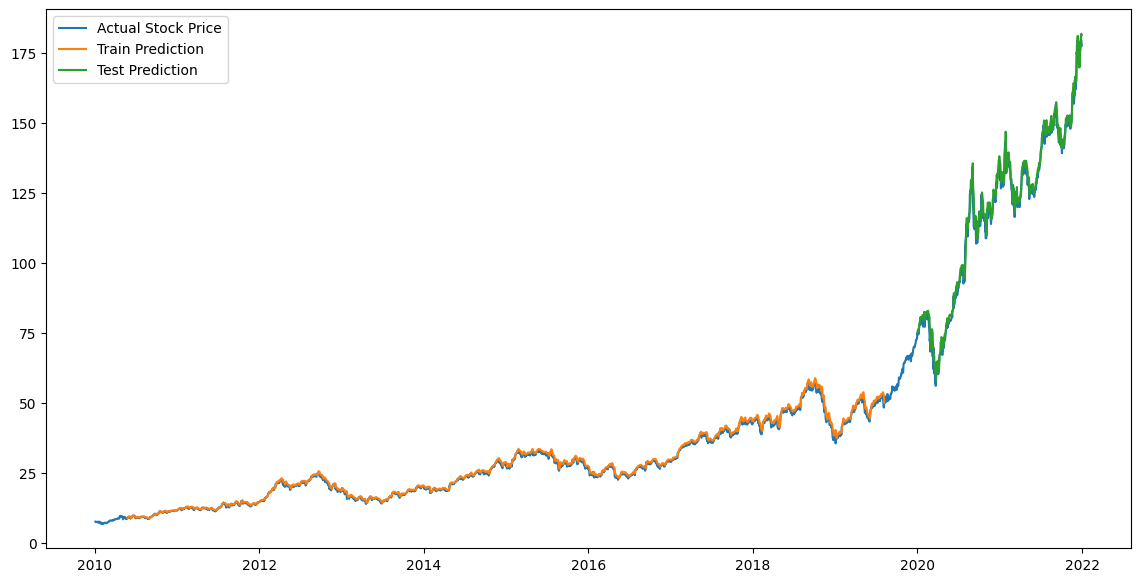

In [3]:
!pip install yfinance

import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load historical stock data
stock_symbol = "AAPL"
start_date = "2010-01-01"
end_date = "2022-01-01"

data = yf.download(stock_symbol, start=start_date, end=end_date)

# Prepare the data
data = data[['Close']]
dataset = data.values
dataset = dataset.astype('float32')

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Split the data into training and testing sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

# Convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Reshape into X=t and Y=t+1
time_step = 100
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=64)
# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])[0]
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])[0]

# Shift train predictions for plotting
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict

# Shift test predictions for plotting
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(dataset) - 1, :] = test_predict

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(data.index, scaler.inverse_transform(dataset), label="Actual Stock Price")
plt.plot(data.index, train_predict_plot, label="Train Prediction")
plt.plot(data.index, test_predict_plot, label="Test Prediction")
plt.legend()
plt.show()
